Importing librairies

In [145]:
import tensorflow as tf
import seaborn as sns
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import random
import cv2
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers, Sequential
from sklearn.model_selection import train_test_split
from tensorflow.keras.applications import EfficientNetB3
from sklearn.metrics import confusion_matrix, accuracy_score

Accessing the files and creating a dataframe with the image id and the name of the animal associated

In [65]:
directory = '/kaggle/input/animals10/raw-img'
name = []
img_id = []

for dirname, _, filenames in os.walk(directory):
    for filename in filenames:
        img_id.append(os.path.join(os.path.basename(dirname),filename))
        name.append(os.path.basename(dirname))
            
df = pd.DataFrame({"img_id":img_id, "name":name})
df.head()

,img_id,name
0,cavallo/OIP-mdvOxIWAyReAoEJcMk5z4wHaJ4.jpeg,cavallo
1,cavallo/OIP-TPYKs3XId_sMgp_6LLA6JgDMEy.jpeg,cavallo
2,cavallo/OIP-jlVRrokx7Vu1axi8OnTX2AHaE2.jpeg,cavallo
3,cavallo/OIP-F4QVZ71QagiynDMnFNxJUAHaEK.jpeg,cavallo
4,cavallo/OIP-UFtUZnXq0JHZo5R8UuF80wHaFj.jpeg,cavallo


Visualising the data distribution

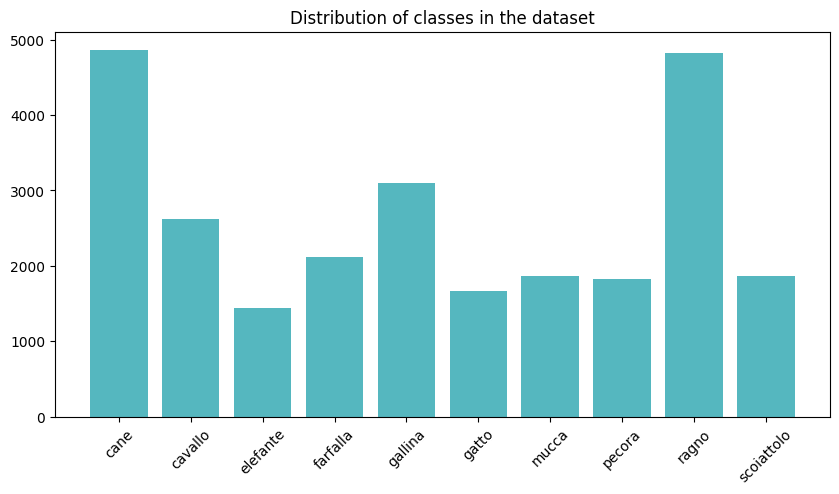

In [3]:
classes, counts = np.unique(df["name"], return_counts=True)

plt.figure(figsize=(10,5))
plt.bar(classes,counts,color="#55B7BF")
plt.xticks(rotation=45)
plt.title("Distribution of classes in the dataset")
plt.show()

Generating a training, validation and testing set.

In [115]:
X = df["img_id"]
y = df["name"]

X_train, X_val_test, y_train, y_val_test = train_test_split(X,y,test_size = 0.2)
X_val, X_test, y_val, y_test = train_test_split(X_val_test,y_val_test,test_size=0.5)

df_train = pd.DataFrame({"img_id":X_train, "name":y_train})
df_val = pd.DataFrame({"img_id":X_val, "name":y_val})
df_test = pd.DataFrame({"img_id":X_test,"name":y_test})

Generating normalised and randomly augmented images from the original images, with a training and validation set.

In [181]:
batch_size = 32
img_size = (224,224)

train_datagen = ImageDataGenerator(
    shear_range=0.2,
    rotation_range=180,
    zoom_range=0.2,
    horizontal_flip=True,
    vertical_flip=True,
    validation_split=0.1) 

val_datagen = ImageDataGenerator()

test_datagen = ImageDataGenerator()

train_generator = train_datagen.flow_from_dataframe(
    directory=directory,
    dataframe=df_train,
    x_col = "img_id",
    y_col = "name",
    shuffle = True,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical') 

val_generator = val_datagen.flow_from_dataframe(
    directory=directory,
    dataframe=df_val,
    x_col = "img_id",
    y_col = "name",
    shuffle = True,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical') 

test_generator = test_datagen.flow_from_dataframe(
    directory=directory,
    dataframe=df_test,
    x_col = "img_id",
    y_col = "name",
    target_size=img_size,
    batch_size=batch_size,
    shuffle = False,
    class_mode="categorical") 

Found 20943 validated image filenames belonging to 10 classes.
Found 2618 validated image filenames belonging to 10 classes.
Found 2618 validated image filenames belonging to 10 classes.


Creating arrays with some of the images generated.

In [95]:
num_batches = 5

images = []
labels = []

for i in range(num_batches):
    batch_data, batch_labels = train_generator.next()
    batch_data /= 255
    images.append(batch_data)

    labels.extend(np.argmax(batch_labels, axis=1))

images = np.concatenate(images, axis=0)

labels = np.array(labels)

Displaying some of the images present in the dataset, except for the spiders pictures.

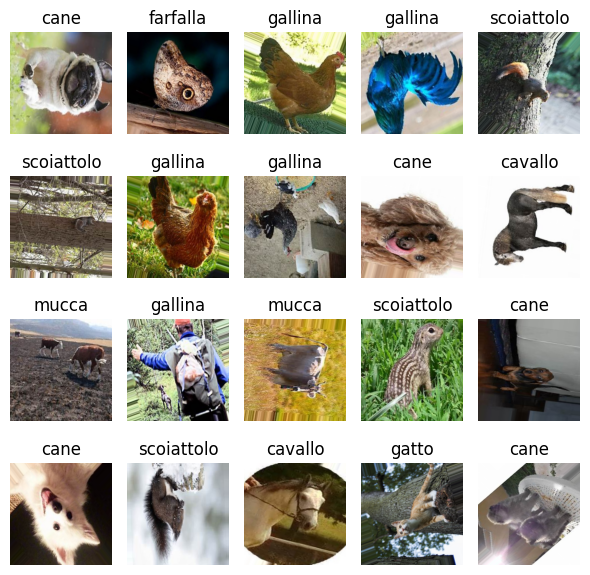

In [96]:
n_rows = 4
n_cols = 5

fig, axes = plt.subplots(n_rows, n_cols, figsize=(6, 6))

for i in range(n_rows):
    for j in range(n_cols):
        r = random.randint(0, len(labels) - 1)

        while labels[r] == 8:
            r = random.randint(0, len(labels) - 1)

        axes[i, j].imshow(images[r])
        axes[i, j].set_title(classes[labels[r]])
        axes[i, j].axis('off') 

plt.tight_layout()
plt.show()

Creating a model using EfficientnetB3

In [101]:
efficient_net = EfficientNetB3(
    weights='imagenet',
    input_shape=(224,224,3),
    include_top=False,
    pooling='max')

model = Sequential()
model.add(efficient_net)
model.add(layers.Dense(1024))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(10, activation='softmax'))
model.summary()

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 efficientnetb3 (Functional  (None, 1536)              10783535  
 )                                                               
                                                                 
 dense_16 (Dense)            (None, 1024)              1573888   
                                                                 
 dropout_8 (Dropout)         (None, 1024)              0         
                                                                 
 dense_17 (Dense)            (None, 10)                10250     
                                                                 
Total params: 12367673 (47.18 MB)
Trainable params: 12280370 (46.85 MB)
Non-trainable params: 87303 (341.03 KB)
_________________________________________________________________


In [102]:
model.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["categorical_accuracy"])

In [103]:
nb_epochs = 5
history = model.fit(
    train_generator,
    steps_per_epoch = train_generator.samples // batch_size,
    validation_data = val_generator, 
    validation_steps = val_generator.samples // batch_size,
    epochs = nb_epochs)

Epoch 1/5


2023-12-04 01:46:38.175976: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential_8/efficientnetb3/block1b_drop/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


654/654 [==============================] - 397s 513ms/step - loss: 0.9841 - categorical_accuracy: 0.8036 - val_loss: 0.3655 - val_categorical_accuracy: 0.8927
Epoch 2/5
654/654 [==============================] - 333s 508ms/step - loss: 0.4717 - categorical_accuracy: 0.8653 - val_loss: 0.5172 - val_categorical_accuracy: 0.8414
Epoch 3/5
654/654 [==============================] - 334s 510ms/step - loss: 0.3809 - categorical_accuracy: 0.8830 - val_loss: 0.3104 - val_categorical_accuracy: 0.9117
Epoch 4/5
654/654 [==============================] - 333s 508ms/step - loss: 0.3343 - categorical_accuracy: 0.8982 - val_loss: 0.3584 - val_categorical_accuracy: 0.8962
Epoch 5/5
654/654 [==============================] - 333s 508ms/step - loss: 0.3064 - categorical_accuracy: 0.9047 - val_loss: 0.3526 - val_categorical_accuracy: 0.8970


Plotting the loss and accuracy

In [131]:
loss = history.history["loss"]
val_loss = history.history["val_loss"]
cat_accuracy = history.history["categorical_accuracy"]
val_cat_accuracy = history.history["val_categorical_accuracy"]
x = np.arange(len(loss))

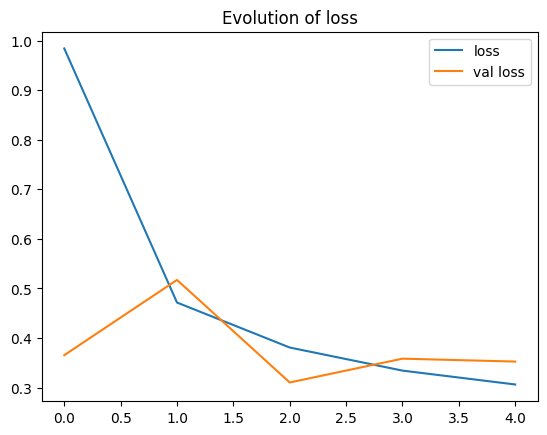

In [132]:
plt.plot(x,loss,label="loss")
plt.plot(x,val_loss,label="val loss")
plt.legend()
plt.title("Evolution of loss")
plt.show()

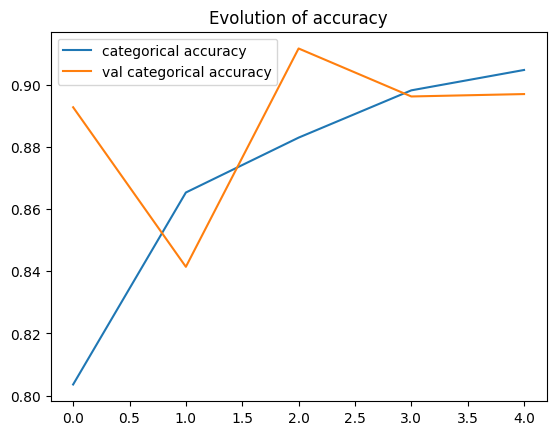

In [133]:
plt.plot(x,cat_accuracy,label="categorical accuracy")
plt.plot(x,val_cat_accuracy,label="val categorical accuracy")
plt.legend()
plt.title("Evolution of accuracy")
plt.show()

Evaluating the model

In [134]:
model.evaluate(test_generator)

82/82 [==============================] - 9s 112ms/step - loss: 0.2702 - categorical_accuracy: 0.9175


[0.2701571583747864, 0.9174942970275879]

Visualising the confusion matrix

In [185]:
y_pred_raw = model.predict(test_generator)
y_pred = np.argmax(preds, axis=1)

82/82 [==============================] - 9s 109ms/step


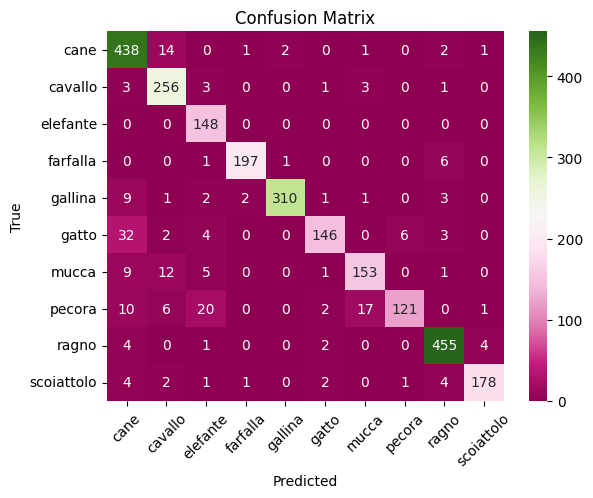

In [208]:
cm = confusion_matrix(test_generator.classes,y_pred)

sns.heatmap(cm, annot=True, fmt="d", cmap="PiYG", xticklabels=classes, yticklabels=classes)

# Add labels and title
plt.xlabel('Predicted')
plt.xticks(rotation=45)
plt.ylabel('True')
plt.title('Confusion Matrix')

# Display the plot
plt.show()

Saving the model

In [144]:
model.save("animal10_classification")

Checking some random images and their predicted names.

In [173]:
N = 500
images = []
names = []
for i in range(N):
    r = random.randint(0,len(df)-1)
    img = cv2.imread(directory+"/"+df["img_id"][r])
    images.append(img)
    names.append(df["name"][r])

1/1 [==============================] - 0s 31ms/step


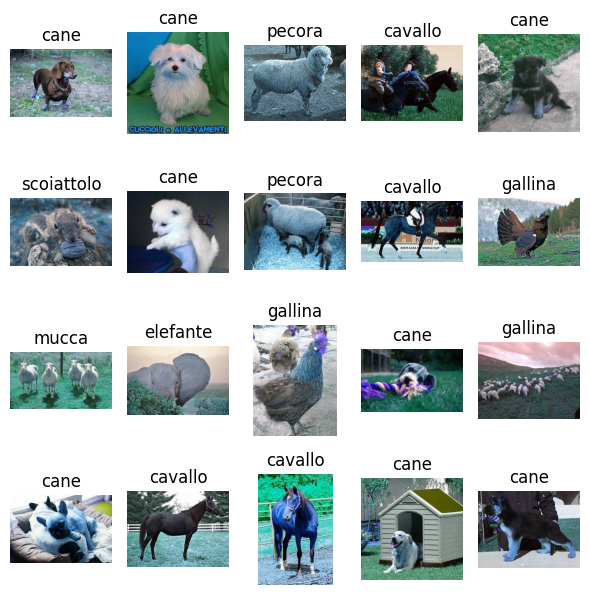

In [176]:
n_rows = 4
n_cols = 5

fig, axes = plt.subplots(n_rows, n_cols, figsize=(6, 6))

for i in range(n_rows):
    for j in range(n_cols):
        
        r = random.randint(0, len(names) - 1)

        while names[r] == "ragno":
            r = random.randint(0, len(names) - 1)
            
        
        img = cv2.resize(images[r],(224,224))
        img = np.expand_dims(img, axis=0)
        name_pred = np.argmax(model.predict(img))



        axes[i, j].imshow(images[r])
        axes[i, j].set_title(classes[name_pred])
        axes[i, j].axis('off') 

plt.tight_layout()
plt.show()